In [1]:
# %pip install --upgrade pip wheel setuptools black isort jupyterlab-code-formatter jupyterthemes jupyterlab_darkside_theme nvitop
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# %pip install --upgrade tensorboard accelerate flash-attn torchtnt bitsandbytes transformers
# %pip install torcheval torchmetrics torchtnt
# %pip install optuna
# !rm ~/.cache/matplotlib -rf

In [2]:
import os
import pickle
from collections import defaultdict
from gc import collect
from glob import glob
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchmetrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm


def _collect():
    print(collect())
    torch.cuda.empty_cache()


# Using 1 year of history data (52 weeks)
window = 52
# Predicting out 8 weeks
n_out = 8
resample_period = "1W"
dataset_type = "df_sales"
max_zeros_in_sku = 0.9

In [3]:
%matplotlib inline

In [4]:
col_to_remove = [
    "amt_disc_ea",
    "amt_gross",
    "amt_net",
    "amt_net_forex",
    "canceled",
    "class_code",
    "code",
    "color_code",
    "cost_center",
    "created_at",
    "currency",
    "customer_code",
    "deleted_at",
    "department_code",
    "discount_granted_excl",
    "discountflag",
    "document_currency",
    "document_number",
    "document_type",
    "family_code",
    "filename",
    "flag_delete",
    "gender_code",
    "geography",
    "gl_account",
    "gl_devise",
    "gl_etablissement",
    "gl_model",
    "gl_numero",
    "gl_numligne",
    "gl_puht",
    "gl_refartbarre",
    "gl_remiseligne",
    "gl_tiers",
    "gl_totalht",
    "gp_refexterne",
    "division",
    "group_code",
    "id",
    "id_class",
    "id_collection",
    "id_color",
    "id_department",
    "id_family",
    "id_gender",
    "id_group",
    "id_loader_job",
    "id_subclass",
    "libdim1",
    "pays",
    "price_ea",
    "product_id",
    "rate",
    "rn",
    "subclass_code",
    "upc",
]

In [5]:
def load_raw_df(
        glob_filter: str = "df_sales*.parquet",
        columns_rename: dict = {
            "gl_datepiece": "date",
            "gl_codearticle": "sku",
            "gl_qtefact": "qty",
        },
):
    df: pd.DataFrame = pd.concat([pd.read_parquet(f) for f in glob(glob_filter)])
    # Removing unuseful columns
    [df.pop(col) for col in col_to_remove if col in df]
    # Renaming columns
    df = df.reset_index(drop=True).rename(columns=columns_rename)

    df["date"] = pd.to_datetime(df["date"])
    df = df.convert_dtypes()

    # Strip text data
    for column in df.select_dtypes(include=[pd.StringDtype]).columns:
        df[column] = df[column].str.strip()

    # Removing null/wrong SKUs - data cleaning on qty
    df = df[~df["sku"].isna()]
    df = df[df["sku"].str.contains(r"\b\w{7}-\w{5}-\w{3}\b")]
    df = df[df["qty"] > 0]

    df["sales_type"] = (
        glob_filter.split("*")[0] if "*" in glob_filter else glob_filter.split(".")[0]
    )
    return df

In [6]:
# raw_dataset_fname = "raw_dataset.parquet"

# if os.path.exists(raw_dataset_fname):
#     df = pd.read_parquet(raw_dataset_fname)
#     # Retain only cegid sales
#     df = df[df["sales_type"] == "df_sales"]
#     dataset_type = "_".join(df["sales_type"].unique())
#     del df["sales_type"]
#     if "date" in df:
#         df.set_index("date", inplace=True)
#     df = df.copy()
# else:
#     df_cl1 = load_raw_df(
#         "cl1_sales*.parquet",
#         {"posting_date": "date", "product_color": "sku", "quantity": "qty"},
#     )
#     df_sales = load_raw_df(
#         "df_sales*.parquet",
#         {"gl_datepiece": "date", "gl_codearticle": "sku", "gl_qtefact": "qty"},
#     )
#     df = pd.concat([df_sales, df_cl1])
#     df.sort_values("date", inplace=True)
#     df.to_parquet(raw_dataset_fname, compression="brotli")
#     df.set_index("date", inplace=True)

# Feature engineering
#### Time
 - Decompose in `t_sin` and `t_cos`
#### Seasons
 - Split `market_seasons` by `|` and concat with `seasons`, `market_season`, `season`
#### Sizes
 - Split `sizes` by `|` and concat with `size`
#### Channels
 - Split `channels` by `|` and concat with `channel`
#### Brands
 - Split `brands` by `|` and concat with `brand`
#### Collections
 - Split `collections` by `|` and concat with `collections`

In [7]:
def get_features(df: pd.DataFrame, col_feature: str):
    features = []
    # Filtering all columns that contains our `col_feature` target
    cols = [col for col in df if col_feature in col]
    for col in cols:
        unique_values = [v for v in df.pop(col).unique() if not pd.isnull(v)]

        for value in unique_values:
            features.extend([v.strip() for v in value.split("|")])
    features = [f for f in list(set(features)) if len(f) > 0]
    df[col_feature] = [features for _ in range(len(df))]

In [8]:
# raw_ts_fname = f"raw_timeseries_{dataset_type}_{resample_period}.parquet"
# if os.path.exists(raw_ts_fname):
#     series = pd.read_parquet(raw_ts_fname)
#     if "date" in series:
#         series.set_index("date", inplace=True)
# else:
#     series_list = []
#     for sku, _df in tqdm(df.groupby("sku")):
#         agg = dict(zip(_df.keys(), ["last"] * len(_df.columns))) | {"qty": "sum"}
#         _series = _df.resample(resample_period).agg(agg).ffill().bfill()
#         [
#             get_features(_series, feature)
#             for feature in ["size", "season", "channel", "brand", "collection"]
#         ]
#         series_list.append(_series)
#     series = pd.concat(series_list).sort_index()
#     series.to_parquet(raw_ts_fname, compression="brotli")

In [9]:
# mask = series.isna().any(axis=1)
# print(
#     f"Removing {len(series.loc[mask, 'sku'].unique())} SKU that does not have categorical data [{mask.sum()}] weeks]"
# )
# series = series[~mask].copy()

In [10]:
def create_timeseries(X, cat, y, window=10, n_out=1, shift=0):
    _X, _cat, _y = [], [], []
    for i in range(len(X) - (window + n_out + shift)):
        _X.append(X[i: i + window])
        _cat.append(cat[i])
        _y.append(y[i + window + shift: i + window + shift + n_out])
    return np.asarray(_X), np.asarray(_cat), np.asarray(_y)


print(np.asarray(range(10)))
_x, _cat, _y = create_timeseries(
    np.asarray(range(10)), np.asarray(range(10)), np.asarray(range(10)), 3, 1, 0
)
_x.shape, _cat.shape, _y.shape, _x, _cat, _y

[0 1 2 3 4 5 6 7 8 9]


((6, 3),
 (6,),
 (6, 1),
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6],
        [5, 6, 7]]),
 array([0, 1, 2, 3, 4, 5]),
 array([[3],
        [4],
        [5],
        [6],
        [7],
        [8]]))

In [11]:
# # Removing SKUs that do not have at least:
# # - 1 example for train and 1 for test
# # - 90% of empty data

# skus_to_remove = (
#     series.groupby("sku")
#     .filter(
#         lambda x: len(x) <= (window + n_out + 2)
#         or (x["qty"] == 0).sum() / len(x) >= max_zeros_in_sku
#     )["sku"]
#     .unique()
# )
# mask = series["sku"].isin(skus_to_remove)
# _percent_sku_removed = round(len(skus_to_remove) / len(series["sku"].unique()) * 100, 2)
# _percent_entries_removed = round(mask.sum() / len(mask) * 100, 2)
# print(
#     f"Removing {_percent_sku_removed}% of SKUs [{_percent_entries_removed}% total entries]"
# )
# series = series[~mask].copy()

In [12]:
# data = series[series["sku"] == "MWL150E-00139-100"]["qty"]
# data.plot()

In [13]:
def remove_outliers(data: pd.Series) -> (pd.Series, bool):
    # Calculate Z-scores
    mean = data.mean()
    std = data.std()
    data_zscore = (data - mean) / std

    # Identify outliers (e.g., |Z| > 3)
    outliers_z = data[abs(data_zscore) > 3]
    has_outliers = len(outliers_z) > 0
    clip_data = None
    if has_outliers:
        clip_data = data.clip(upper=mean + 3 * std, lower=mean - 3 * std)

    return clip_data, has_outliers

In [14]:
# max_value = series["qty"].max()
# for dtype in [np.float16, np.float32, np.float64]:
#     if max_value <= np.finfo(dtype).max:
#         print(f"Setting dtype: {dtype}")
#         series["qty"] = series["qty"].astype(dtype)
#         break

In [15]:
n_outliers = 0
filtered_ts_fname = (
    f"filtered_timeseries_{dataset_type}_{resample_period}_{max_zeros_in_sku}.parquet"
)
if os.path.exists(filtered_ts_fname):
    series = pd.read_parquet(filtered_ts_fname)
else:
    for sku in tqdm(series["sku"].unique()):
        mask = series["sku"] == sku
        data, has_outliers = remove_outliers(series.loc[mask, "qty"])
        if has_outliers:
            n_outliers += 1
            series.loc[mask, "qty"] = data
    print(f"Removed {n_outliers} outliers")
    series = series.convert_dtypes()
    series.to_parquet(filtered_ts_fname, compression="brotli")

# Creating categorical features

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=42)
series["bins"] = kmeans.fit_predict(series[["qty"]])
categorical_features = [
    c for c in series.columns if c not in {"sku", "qty", "description", "bins"}
]
categorical_features

In [18]:
label_encoders = {c: MultiLabelBinarizer() for c in categorical_features} | {
    "bins": LabelBinarizer()
}
label_encoders

{'composition': MultiLabelBinarizer(),
 'gender_description': MultiLabelBinarizer(),
 'department_description': MultiLabelBinarizer(),
 'class_description': MultiLabelBinarizer(),
 'group_description': MultiLabelBinarizer(),
 'color_description': MultiLabelBinarizer(),
 'family_description': MultiLabelBinarizer(),
 'subclass_description': MultiLabelBinarizer(),
 'size': MultiLabelBinarizer(),
 'season': MultiLabelBinarizer(),
 'channel': MultiLabelBinarizer(),
 'brand': MultiLabelBinarizer(),
 'collection': MultiLabelBinarizer(),
 'bins': LabelBinarizer()}

In [19]:
for column, label_encoder in tqdm(label_encoders.items()):
    label_encoder.fit(series[column].reset_index(drop=True))
    series[f"encoded_{column}"] = label_encoder.transform(
        series[column].reset_index(drop=True)
    ).tolist()

  0%|          | 0/14 [00:00<?, ?it/s]

In [20]:
sku_to_index = {sku: idx for idx, sku in enumerate(series["sku"].unique())}
series["sku_code"] = series["sku"].map(sku_to_index)

<Axes: xlabel='date'>

<Axes: xlabel='date'>

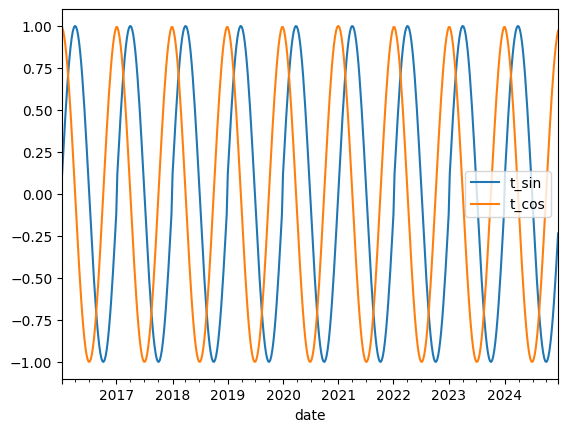

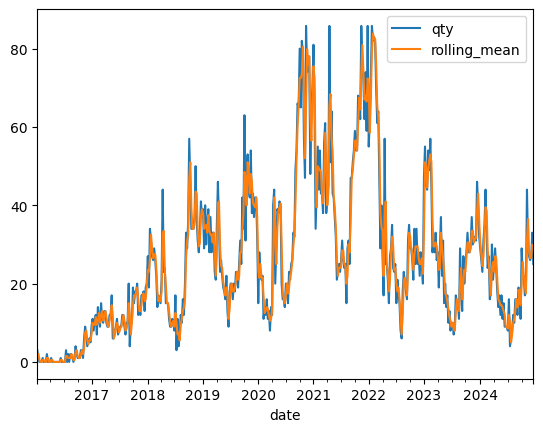

In [21]:
# Create time features. Decompose the time "signal" using cos and sin coordinates.
# By this, the first week of the year is nearest point of the last week instead of the farthest.
# FIXME: We use only the week number (1-52 i think), add features related to holiday and month instead of the week number only)
# FIXME: Take care about the COVID period in order to add an external bias factor for influence the 2020-2022 sales.
#   Note that batch size can influence the generalization of the network and reduce the sales due to the decrease of the sales.
calendar = series.index.isocalendar().week
series["t_sin"] = np.sin(calendar * (2 * np.pi / calendar.max()))
series["t_cos"] = np.cos(calendar * (2 * np.pi / calendar.max()))

display(series[series["sku"] == "MJQ008H-00535-461"][["t_sin", "t_cos"]].plot())
t = series[series["sku"] == "MJQ008H-00535-461"][["qty"]]
t["rolling_mean"] = t["qty"].rolling(2).mean()
t.plot()

In [22]:
sku_list = series.pop("sku")

In [23]:
encoded_categorical_features = [c for c in series.columns if "encoded" in c]
series_fname = f"series_{dataset_type}_{max_zeros_in_sku}_with_bins.pkl"
if os.path.exists(series_fname):
    with open(series_fname, "rb") as f:
        (
            ts_train_x_dataset,
            ts_train_cat_dataset,
            ts_train_y_dataset,
            ts_test_x_dataset,
            ts_test_cat_dataset,
            ts_test_y_dataset,
        ) = pickle.load(f)
else:
    ts_train_x_dataset = []
    ts_train_cat_dataset = []
    ts_train_y_dataset = []
    ts_test_x_dataset = []
    ts_test_cat_dataset = []
    ts_test_y_dataset = []
    grouped = series.groupby("sku_code")
    series_features = [
        "qty",
        "sku_code",
        "t_sin",
        "t_cos",
    ]
    for idx, (sku, _series) in enumerate(tqdm(grouped)):
        categorical_data = (
            _series[encoded_categorical_features]
            .iloc[0]
            .apply(lambda x: np.asarray(x, dtype=np.bool_))
            .values
        )

        _ts, _cat, _y = create_timeseries(
            _series[series_features],
            [categorical_data] * len(_series),
            _series[["qty", "encoded_bins"]],
            window=window,
            n_out=n_out,
        )

        _ts_train, _ts_test, _cat_train, _cat_test, _y_train, _y_test = (
            train_test_split(_ts, _cat, _y, test_size=0.2, shuffle=False)
        )
        ts_train_x_dataset.extend(_ts_train)
        ts_test_x_dataset.extend(_ts_test)
        ts_train_cat_dataset.extend(_cat_train)
        ts_test_cat_dataset.extend(_cat_test)
        ts_train_y_dataset.extend(_y_train)
        ts_test_y_dataset.extend(_y_test)
    ts_train_x_dataset = np.asarray(ts_train_x_dataset)
    ts_train_y_dataset = np.asarray(ts_train_y_dataset)
    ts_train_cat_dataset = np.asarray(ts_train_cat_dataset)
    ts_test_x_dataset = np.asarray(ts_test_x_dataset)
    ts_test_y_dataset = np.asarray(ts_test_y_dataset)
    ts_test_cat_dataset = np.asarray(ts_test_cat_dataset)
    with open(series_fname, "wb") as f:
        pickle.dump(
            (
                ts_train_x_dataset,
                ts_train_cat_dataset,
                ts_train_y_dataset,
                ts_test_x_dataset,
                ts_test_cat_dataset,
                ts_test_y_dataset,
            ),
            f,
            pickle.HIGHEST_PROTOCOL,
        )
del series
_collect()
ts_train_x_dataset.shape, ts_train_cat_dataset.shape, ts_train_y_dataset.shape

6855


((594114, 52, 4), (594114, 14), (594114, 8, 2))

In [24]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler().fit(ts_train_x_dataset[:, :, 0])
scaler_y = StandardScaler().fit(ts_train_y_dataset[:, :, 0])

ts_train_x_dataset[:, :, 0] = scaler_x.transform(ts_train_x_dataset[:, :, 0])
ts_test_x_dataset[:, :, 0] = scaler_x.transform(ts_test_x_dataset[:, :, 0])

ts_train_y_dataset[:, :, 0] = scaler_y.transform(ts_train_y_dataset[:, :, 0])
ts_test_y_dataset[:, :, 0] = scaler_y.transform(ts_test_y_dataset[:, :, 0])

In [25]:
for x, cat, y in zip(ts_test_x_dataset, ts_test_cat_dataset, ts_test_y_dataset):
    print(x.shape, [_.shape for _ in cat], y.shape)
    break

(52, 4) [(62,), (12,), (21,), (29,), (25,), (25,), (26,), (37,), (125,), (53,), (7,), (5,), (119,), (15,)] (8, 2)


In [26]:
class DemandDataset(Dataset):
    def __init__(self, raw_dataset, cat_dataset, y):
        self.raw_dataset = raw_dataset
        self.cat_dataset = cat_dataset
        self.y = y

    def __len__(self):
        return len(self.raw_dataset)

    def __getitem__(self, idx):
        return {
            "sequence": self.raw_dataset[idx],
            "y": self.y[idx],
            "categorical_data": self.cat_dataset[idx],
        }

    def collate_fn(self, batch):
        qty = torch.as_tensor(
            np.asarray([x["sequence"][:, 0] for x in batch], dtype=np.float32),
            dtype=torch.float32,
        ).unsqueeze(-1)
        sku = torch.as_tensor(
            np.asarray([x["sequence"][:, 1][0] for x in batch], dtype=np.int32),
            dtype=torch.int32,
        )
        time = torch.as_tensor(
            np.asarray([x["sequence"][:, 2:] for x in batch], dtype=np.float32),
            dtype=torch.float32,
        )
        y = torch.as_tensor(
            np.asarray([x["y"][:, 0] for x in batch], dtype=np.float32),
            dtype=torch.float32,
        )

        y_cat = []
        for entry in batch:
            x = np.vstack(entry["y"][:, 1])
            y_cat.append(x)

        cats = defaultdict(list)
        for entry in batch:
            v = dict(zip(encoded_categorical_features, entry["categorical_data"]))
            for k, v in v.items():
                cats[k].append(v)
        for k in cats:
            cats[k] = torch.as_tensor(np.asarray(cats[k]), dtype=torch.bool)

        return {
            "qty": qty,
            "sku": sku,
            "time": time,
            "y": y,
            "y_cat": torch.as_tensor(np.asarray(y_cat), dtype=torch.float32),
            "cats": cats,
        }


_collect()

In [41]:
batch_size = 512
num_workers = 2
early_stop = {'patience': 3, 'min_delta': 0.3}


def init_ds(batch_size, num_workers):
    pin_memory = True
    device = torch.device("cpu")
    if not torch.cuda.is_available():
        pin_memory = False
        num_workers = 0
        batch_size = 32

    ds_train = DemandDataset(ts_train_x_dataset, ts_train_cat_dataset, ts_train_y_dataset)
    dl_train = DataLoader(
        ds_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=ds_train.collate_fn,
        pin_memory=pin_memory,
        drop_last=True,
    )

    ds_test = DemandDataset(ts_test_x_dataset, ts_test_cat_dataset, ts_test_y_dataset)
    dl_test = DataLoader(
        ds_test,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=ds_test.collate_fn,
        pin_memory=pin_memory,
        drop_last=True,
    )
    if torch.cuda.is_available():
        device = torch.device("cuda")
        from torchtnt.utils.data import CudaDataPrefetcher

        dl_train = CudaDataPrefetcher(dl_train, device, 64)
        dl_test = CudaDataPrefetcher(dl_test, device, 64)
    return device, dl_train, dl_test, ds_train, ds_test


def init_metrics():
    metrics_names = [v for v in dir(torchmetrics.regression) if v[0].isupper()]
    metrics = {}
    target = torch.tensor([[2.5, 5, 4, 8], [3, 5, 2.5, 7]])
    preds = torch.tensor([[3, 5, 2.5, 7], [2.5, 5, 4, 8]])
    for metric_name in metrics_names:
        try:
            metric = getattr(torchmetrics, metric_name)()
            metric(preds, target)
            metrics[metric_name] = metric
        except Exception as e:
            print('Skipping ', metric_name, e)
    del metrics['KLDivergence']
    del metrics['CosineSimilarity']
    return metrics


device, dl_train, dl_test, ds_train, ds_test = init_ds(batch_size, num_workers)
metrics = init_metrics()

Skipping  ConcordanceCorrCoef Expected argument `num_outputs` to match the second dimension of input, but got 1 and 4.
Skipping  CriticalSuccessIndex CriticalSuccessIndex.__init__() missing 1 required positional argument: 'threshold'
Skipping  KendallRankCorrCoef Expected argument `num_outputs` to match the second dimension of input, but got 1 and 4.
Skipping  LogCoshError Expected argument `num_outputs` to match the second dimension of input, but got 1 and 4.
Skipping  MinkowskiDistance MinkowskiDistance.__init__() missing 1 required positional argument: 'p'
Skipping  PearsonCorrCoef Expected argument `num_outputs` to match the second dimension of input, but got 1 and 4.
Skipping  RelativeSquaredError output with shape [1] doesn't match the broadcast shape [4]
Skipping  SpearmanCorrCoef Expected argument `num_outputs` to match the second dimension of input, but got 1 and 4.


In [28]:
for x_ds in ds_train:
    break
for x_dl in dl_train:
    break

In [29]:
encoded_features_shape = {}
for k, v in x_dl.items():
    if k == "cats":
        encoded_features_shape.update(
            {"cats": {k: _v.shape[-1] for k, _v in v.items()}}
        )
    else:
        encoded_features_shape.update({k: v.shape[-1]})
pprint(encoded_features_shape)
sku_vocab_size = len(sku_to_index)
cat_features_shapes = encoded_features_shape["cats"]
time_features_dim = encoded_features_shape["time"]

del x_ds, x_dl
_collect()

{'cats': {'encoded_bins': 15,
          'encoded_brand': 5,
          'encoded_channel': 7,
          'encoded_class_description': 29,
          'encoded_collection': 119,
          'encoded_color_description': 25,
          'encoded_composition': 62,
          'encoded_department_description': 21,
          'encoded_family_description': 26,
          'encoded_gender_description': 12,
          'encoded_group_description': 25,
          'encoded_season': 53,
          'encoded_size': 125,
          'encoded_subclass_description': 37},
 'qty': 1,
 'sku': 512,
 'time': 2,
 'y': 8,
 'y_cat': 15}
155


In [30]:
def plot_model(model, batch):
    from torchviz import make_dot

    qty = batch["qty"]  # [batch_size, 52, 1]
    time = batch["time"]  # [batch_size, 52, 2]
    sku = batch["sku"]  # [batch_size]
    # Maybe it is not necessary. To save memory, we save the categorical matrix data as boolean (True/False instead of 1/0)
    cats = {
        key: value.to(dtype=torch.int32) for key, value in batch["cats"].items()
    }

    # Forward pass return both regression and classification
    outputs, class_preds = model(
        qty, time, sku, cats
    )
    return make_dot((outputs, class_preds), params=dict(model.named_parameters()))


In [42]:
from typing import Dict


class DemandForecastingModel(nn.Module):
    def __init__(
            self,
            sku_vocab_size: int,
            sku_emb_dim: int,
            cat_features_dim: Dict[str, int],
            cat_emb_dims: int,
            time_features_dim: int,
            lstm_bidirectional: bool,
            lstm_hidden_size: int,
            lstm_layers: int,
            linear_hidden_size: int,
            dropout: float,
            n_out: int,

    ):
        super(DemandForecastingModel, self).__init__()
        # SKU Embedding
        self.sku_embedding = nn.Embedding(sku_vocab_size, sku_emb_dim)

        # Categorical Feature Embeddings
        self.cat_embeddings = nn.ModuleDict(
            {
                name: nn.Embedding(vocab_size, emb_dim)
                for name, vocab_size, emb_dim in zip(
                cat_features_dim.keys(),
                cat_features_dim.values(),
                [cat_emb_dims] * len(cat_features_dim),
            )
            }
        )

        # LSTM for time-series data
        self.lstm = nn.LSTM(
            input_size=1 + time_features_dim,  # qty (1) + time (2)
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=lstm_bidirectional,
            dropout=dropout,
        )
        out_lstm_hidden_size = lstm_hidden_size
        if lstm_bidirectional:
            out_lstm_hidden_size = lstm_hidden_size * 2
        # Fully connected layer for final predictions
        total_cat_emb_dim = cat_emb_dims * len(cat_features_dim) + sku_emb_dim
        self.fc = nn.Sequential(
            nn.Linear(out_lstm_hidden_size + total_cat_emb_dim, (out_lstm_hidden_size + total_cat_emb_dim) // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear((out_lstm_hidden_size + total_cat_emb_dim) // 2, lstm_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden_size, n_out),
        )

        self.fc_class = nn.Sequential(
            nn.Linear(out_lstm_hidden_size + total_cat_emb_dim, (out_lstm_hidden_size + total_cat_emb_dim) // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear((out_lstm_hidden_size + total_cat_emb_dim) // 2, linear_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(linear_hidden_size, cat_features_shapes["encoded_bins"] * n_out),
        )

    def forward(self, qty, time, sku, cats):
        # SKU Embedding
        sku_emb = self.sku_embedding(sku)

        # Categorical Embeddings
        # FIXME: We are using the `mean`, migrate to MaxPool/Attention or other smarter ways
        cat_embs = [
            emb(cats[name]).mean(axis=1) for name, emb in self.cat_embeddings.items()
        ]

        cat_embs = torch.cat(cat_embs, dim=1)  # [batch_size, total_cat_emb_dim]

        # FIXME: Use an LSTM for the QTY and one for the TIME?
        # Time-Series Data Processing
        x = torch.cat([qty, time], dim=-1)  # Combine qty and time [batch_size, 52, 3]
        lstm_out, _ = self.lstm(x)  # [batch_size, window, lstm_hidden_size * (2 * lstm_bidirectional)]
        # Take the last time step [batch_size, lstm_hidden_size * (2 * lstm_bidirectional)]
        lstm_out = lstm_out[:, -1, :]

        # Feature Fusion
        # [batch_size, lstm_hidden_size * (2 * lstm_bidirectional) + total_cat_emb_dim]
        combined_features = torch.cat(
            [lstm_out, sku_emb, cat_embs], dim=-1
        )

        # Final Prediction
        output = self.fc(combined_features)  # [batch_size, n_out]

        classification_logits = self.fc_class(combined_features)  # [batch_size, n_out * num_classes]

        # Reshape for classification output: [batch_size, n_out, num_classes]
        classification_output = classification_logits.view(
            -1, n_out, cat_features_shapes["encoded_bins"]
        )

        return output, classification_output

In [45]:
 def core(batch, regression_criterion, classification_criterion, model):
    qty = batch["qty"]  # [batch_size, 52, 1]
    time = batch["time"]  # [batch_size, 52, 2]
    sku = batch["sku"]  # [batch_size]
    # Maybe it is not necessary. To save memory, we save the categorical matrix data as boolean (True/False instead of 1/0)
    cats = {
        key: value.to(dtype=torch.int32) for key, value in batch["cats"].items()
    }
    y_class = torch.argmax(batch["y_cat"], dim=-1)  # [batch_size, n_out]
    targets = batch["y"]

    # Forward pass return both regression and classification
    outputs, class_preds = model(
        qty, time, sku, cats
    )
    # Use the sum of each value to reduce "global batch distance" from targets (from `[batch_size, n_out]` to `[batch_size]`)
    flatten_outputs = torch.sum(outputs, dim=-1)
    flatten_targets = torch.sum(targets, dim=-1)

    # Compute regression loss
    regression_loss = regression_criterion(
        flatten_outputs, flatten_targets
    )

    # Compute classification loss (targets should be [batch_size, n_out])
    classification_loss = classification_criterion(
        # Flatten classification logits to [batch_size * n_out, num_classes]
        class_preds.view(-1, class_preds.size(-1)),
        # Flatten targets to [batch_size * n_out]
        y_class.view(-1),
    )

    # Combine losses with a weighting factor
    alpha = 1.0  # Weight for regression loss
    beta = 1.0  # Weight for classification loss
    loss = alpha * regression_loss + beta * classification_loss

    return loss, outputs, targets, flatten_outputs, flatten_targets


# Validation on the test dataset
def validate_model(model, dataloader, regression_criterion, classification_criterion, batch_size, plot=False):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    flatten_predictions, flatten_actuals, predictions, actuals = [], [], [], []
    _skus = []
    if device.type == "cuda":
        total_steps = len(dataloader.data_iterable.dataset) // batch_size
    else:
        total_steps = len(dataloader.dataset) // batch_size

    with torch.no_grad():
        for batch in tqdm(dataloader, total=total_steps, leave=False):
            loss, outputs, targets, flatten_outputs, flatten_targets = core(batch, regression_criterion,
                                                                            classification_criterion, model)
            total_loss += loss.item()

            # Store predictions and actual values
            flatten_predictions.extend(flatten_outputs.squeeze().detach().cpu().numpy())
            flatten_actuals.extend(flatten_targets.detach().cpu().numpy())
            predictions.extend(outputs.squeeze().detach().cpu().numpy())
            actuals.extend(targets.detach().cpu().numpy())
            _skus.extend(batch["sku"].detach().cpu().numpy())

    avg_loss = total_loss / total_steps

    # Calculate performance metrics
    _actuals = np.array(actuals)
    _predictions = np.array(predictions)
    res = _actuals - _predictions

    _flatten_actuals = np.array(flatten_actuals)
    _flatten_predictions = np.array(flatten_predictions)
    flatten_res = _flatten_actuals - _flatten_predictions

    mse = np.mean(res ** 2)
    mae = np.mean(np.abs(res))
    flatten_mse = np.mean(flatten_res ** 2)
    flatten_mae = np.mean(np.abs(flatten_res))

    # Plot predictions vs actuals
    s_res = f"Loss: {avg_loss:.4f} MSE: {mse:.4f} MAE: {mae:.4f} FLAT_MSE: {flatten_mse:.4f} FLAT_MAE: {flatten_mae:.4f}"
    if plot:
        plt.figure(figsize=(20, 10))
        plt.plot(flatten_actuals, label="Actual", color="blue")
        plt.plot(flatten_predictions, label="Predicted", color="red", linestyle="dashed")
        plt.title(s_res)
        plt.xlabel("Sample Index")
        plt.ylabel("Quantity")
        plt.legend(loc='upper right')
        plt.grid()
        plt.show()

    print(
        f"Validation Results:\n{s_res}"
    )
    _p, _a = torch.as_tensor(flatten_predictions), torch.as_tensor(flatten_actuals)
    _res_metric = {}
    for metric_name, metric in metrics.items():
        try:
            _res_metric[metric_name] = metric(_p, _a).item()
        except Exception:
            print('skipping', metric_name)

    return {'predictions': predictions,
            'actuals': actuals,
            'flatten_predictions': flatten_predictions,
            'flatten_actuals': flatten_actuals,
            'skus': _skus,
            'avg_loss': avg_loss,
            'mse': mse,
            'mae': mae,
            'flatten_mse': flatten_mse,
            'flatten_mae': flatten_mae,
            'metrics': _res_metric}


# Training Loop
def train_model(
        model,
        dataloader_train,
        dataloader_test,
        regression_criterion,
        classification_criterion,
        optimizer,
        num_epochs,
        batch_size,
        device,
        early_stop: Dict[str, int] = early_stop,
        plot_n_epochs=1000,
):
    model.train()
    if device.type == "cuda":
        total_steps = len(dataloader_train.data_iterable.dataset) // batch_size
    else:
        total_steps = len(dataloader_train.dataset) // batch_size

    best_metric = float('inf')
    epochs_no_improve = 0
    best_model = None

    for epoch in tqdm(range(num_epochs), desc="epochs", position=0):
        epoch_loss = 0.0
        model.train()
        for batch in tqdm(dataloader_train, position=1, leave=False, total=total_steps):
            loss, _, _, _, _ = core(batch, regression_criterion, classification_criterion, model)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / total_steps:.4f}")
        val_metrics = validate_model(
            model,
            dataloader_test,
            regression_criterion,
            classification_criterion,
            batch_size,
            plot=(epoch + 1) % plot_n_epochs == 0
        )

        flatten_mse = val_metrics['flatten_mse']
        if flatten_mse < best_metric - early_stop['min_delta']:
            best_metric = flatten_mse
            epochs_no_improve = 0
            best_model = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve == early_stop['patience']:
                print(f"Early stopping triggered after {epoch + 1} epochs!")
                model.load_state_dict(best_model)
                return

In [ ]:
import optuna
from torch import optim


def objective(trial: optuna.Trial) -> float:
    # Define the hyperparameters to tune
    sku_emb_dim = trial.suggest_categorical("sku_emb_dim", choices=[16, 32, 96, 128])
    cat_emb_dims = trial.suggest_categorical("cat_emb_dims", choices=[16, 32, 96, 128, 256])
    lstm_hidden_size = trial.suggest_categorical("lstm_hidden_size", choices=[160, 196, 256])
    linear_hidden_size = trial.suggest_categorical("linear_hidden_size", choices=[64, 160, 200])
    lstm_layers = trial.suggest_categorical("lstm_layers", choices=[1, 2, 3, 4])
    learning_rate = trial.suggest_categorical("learning_rate", choices=[0.001, 0.0001, 0.0005])
    dropout = trial.suggest_categorical("dropout", choices=[0.1, 0.2, 0.3])
    batch_size = trial.suggest_categorical("batch_size", choices=[256, 512, 1024])
    num_epochs = 10
    lstm_bidirectional = True
    # Initialize the model with trial hyperparameters
    device, dl_train, dl_test, ds_train, ds_test = init_ds(batch_size, 6)
    model = DemandForecastingModel(
        sku_vocab_size,
        sku_emb_dim,
        cat_features_shapes,
        cat_emb_dims,
        time_features_dim,
        lstm_bidirectional,
        lstm_hidden_size,
        lstm_layers,
        linear_hidden_size,
        dropout,
        n_out,
    ).to(device)

    # Define the loss functions and optimizer
    regression_criterion = nn.MSELoss()
    classification_criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # Train the model
    train_model(model, dl_train, dl_test, regression_criterion, classification_criterion, optimizer, num_epochs,
                batch_size, device)

    # Validate the model
    val_metrics = validate_model(
        model,
        dl_test,
        regression_criterion,
        classification_criterion,
        batch_size,
        True
    )
    pprint(val_metrics)
    return val_metrics['flatten_mse']


# Create a study
study = optuna.create_study(direction="minimize")

# Optimize the study
study.optimize(objective, n_trials=70, gc_after_trial=True, show_progress_bar=True, catch=[Exception])

# Print the best parameters and value
print("Best Parameters:", study.best_params)
print("Best Validation Loss:", study.best_value)
print(vars(study.best_trials[0]))

[I 2024-12-24 20:43:15,946] A new study created in memory with name: no-name-62fabe26-c796-41a1-bb21-f58a34b77a04


  0%|          | 0/70 [00:00<?, ?it/s]

epochs:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/290 [00:00<?, ?it/s]

In [ ]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank
from optuna.visualization import plot_slice
from optuna.visualization import plot_timeline
from plotly.io import show

for _plot in [plot_contour, plot_edf, plot_intermediate_values, plot_optimization_history, plot_parallel_coordinate,
              plot_param_importances, plot_rank, plot_slice, plot_timeline]:
    show(_plot(study))

In [ ]:
# Hyperparameters

# {'sku_emb_dim': 64,
#  'cat_emb_dims': 32,
#  'hidden_size': 224,
#  'lstm_layers': 2,
#  'learning_rate': 0.00010887303302066533,
#  'batch_size': 512}

sku_emb_dim = 32
cat_emb_dims = 32
linear_hidden_size = 128
lstm_hidden_size = 32
lstm_bidirectional = True
lstm_layers = 2
learning_rate = 0.0001
batch_size = 512
num_epochs = 30
dropout = 0.3

_collect()
device, dl_train, dl_test, _, _ = init_ds(batch_size, 5)

model = DemandForecastingModel(
    sku_vocab_size,
    sku_emb_dim,
    cat_features_shapes,
    cat_emb_dims,
    time_features_dim,
    lstm_bidirectional,
    lstm_hidden_size,
    lstm_layers,
    linear_hidden_size,
    dropout,
    n_out,
).to(device)

for batch in dl_train:
    break
dot = plot_model(model, batch)
dot.format = 'svg'
dot.render()
del batch

# Define the loss functions and optimizer
regression_criterion = nn.MSELoss()
classification_criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_model(model, dl_train, regression_criterion, classification_criterion, optimizer, num_epochs, batch_size, device)

In [ ]:
# Validate the model on the test dataset
val_metrics = validate_model(
    model,
    dl_test,
    regression_criterion,
    classification_criterion,
    batch_size,
    True
)

In [ ]:
predictions = scaler_y.inverse_transform(val_metrics['predictions']).round()
actuals = scaler_y.inverse_transform(val_metrics['actuals']).round()
d_preds = defaultdict(list)
sku_to_index_inv = {v: k for k, v in sku_to_index.items()}
for _pred, _y, _sku in zip(predictions, actuals, [sku_to_index_inv[sku] for sku in val_metrics['skus']]):
    d_preds[_sku].append(
        {"preds": _pred, "y": _y, "preds_sum": _pred.sum(), "y_sum": _y.sum()}
    )

In [ ]:
for idx, (k, v) in enumerate(d_preds.items()):
    if idx == 6:
        break


In [ ]:
_v = pd.DataFrame(v)
for _, row in _v.iterrows():
    x = list(range(len(row['y'])))
    delta = abs(row['preds'] - row['y'])
    plt.plot(x, row['y'], label='True Values', marker='o', linestyle='-')
    plt.plot(x, row['preds'], label='Predictions', marker='x', linestyle='--')
    plt.plot(x, delta, label='Delta', marker='x', linestyle=':')

    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title('Predictions vs. True Values')
    plt.legend()
    plt.show()